In [1]:
import numpy as np
from PIL import Image
import logging.config
# Logging setup
#logging.config.fileConfig(fname='logging.conf', disable_existing_loggers=False)
log = logging.getLogger(__name__)
from matplotlib import pyplot as plt
from PIL import Image


In [2]:
# Attempting to use mkl_fft (faster FFT library for Intel CPUs). Fallback is np
try:
    import mkl_fft as m

    fft2 = m.fft2
    ifft2 = m.ifft2
except (ModuleNotFoundError, ImportError):
    fft2 = np.fft.fft2
    ifft2 = np.fft.ifft2
finally:
    fftshift = np.fft.fftshift
    ifftshift = np.fft.ifftshift

In [3]:
def open_file(path: str, dtype: np.dtype = np.float32) -> np.ndarray:
    """Tries to load image data into a NumPy ndarray
    The function first tries to use the PIL Image library to identify and load
    the image. PIL will convert the image to 8-bit pixels, black and white.
    If PIL fails pydicom is the next choice.
    Parameters:
        path (str): The image file location
        dtype (np.dtype): image array dtype (e.g. np.float64)
    Returns:
        np.ndarray: a floating point NumPy ndarray of the specified dtype
    """

    log.info(f'Opening file: {path}')
    with Image.open(path) as f:
        img_file = f.convert('F')  # 'F' mode: 32-bit floating point pixels
        img_pixel_array = np.array(img_file).astype(dtype)
    log.info(f"Image loaded. Image size: {img_pixel_array.shape}")
    return img_pixel_array

In [38]:
def np_fft(img: np.ndarray):
        """ Performs FFT function (image to kspace)
        Performs FFT function, FFT shift and stores the unmodified kspace data
        in a variable and also saves one copy for display and edit purposes.
        Parameters:
            img (np.ndarray): The NumPy ndarray to be transformed
            out (np.ndarray): Array to store output (must be same shape as img)
        """
        kspacedata = np.zeros_like(img, dtype=np.complex64)
        return np.fft.fftshift(fft2(ifftshift(img))) 
    
def np_ifft(kspace: np.ndarray):
        """Performs inverse FFT function (kspace to [magnitude] image)
        Performs iFFT on the input data and updates the display variables for
        the image domain (magnitude) image and the kspace as well.
        Parameters:
            kspace (np.ndarray): Complex kspace ndarray
            out (np.ndarray): Array to store values
        """
        img = np.zeros_like(kspace, dtype=np.float32)
        return np.absolute(np.fft.fftshift(ifft2(ifftshift(kspace))))


def low_pass_filter(kspace: np.ndarray, factor: float):
    """Low pass filter removes the high spatial frequencies from k-space
    This function only keeps the center of kspace by removing values
    outside a circle of given size. The circle's radius is determined by
    the 'radius' float variable (0.0 - 100) as ratio of the lenght of
    the image diagonally
    Parameters:
        kspace (np.ndarray): Complex kspace data
        radius (float): Relative size of the kspace mask circle (percent)
    """
    kspace_data = np.zeros_like(kspace, dtype=np.complex64)
    kspace_data[:] = kspace[:]
    #original r
    #r = np.hypot(*kspace_data.shape) / 2
    #new r
    #new_r = np.sqrt(r**2 *(1/factor))
    #print("old radius and new radius:",r,new_r)
    rows, cols = np.array(kspace_data.shape, dtype=int)
    area_trans = rows*cols/factor
    r_trans = np.sqrt(area_trans/(2*np.pi))
    a, b = np.floor(np.array((rows, cols)) / 2).astype(int)
    y, x = np.ogrid[-a:rows - a, -b:cols - b]
    mask = x * x + y * y <= r_trans * r_trans*2
    
    kspace_data[~mask] = 0
    return kspace_data


    

def normalise(f: np.ndarray):
    """ Normalises array by "streching" all values to be between 0-255.
    Parameters:
        f (np.ndarray): input array
    """
    fmin = float(np.min(f))
    fmax = float(np.max(f))
    if fmax != fmin:
        coeff = fmax - fmin
        f[:] = np.floor((f[:] - fmin) / coeff * 255.)
        
    return f

def display(kspacedata):
    kspace_abs = np.absolute(kspacedata)
    kscale = 2
    if np.any(kspace_abs):
        scaling_c = np.power(10., kscale)
        kspace_abs = np.log1p(kspace_abs * scaling_c)
        ksapce_abs = normalise(kspace_abs)

    # 3. Obtain uint8 type arrays for QML display
    #self.image_display_data[:] = np.require(self.img, np.uint8)
    ksapce_abs= np.require(kspace_abs, np.uint8)

    return ksapce_abs


def generate_low_resolution(img):
    kspace = np_fft(img)
    
    #ksapce low_pass_filter
    img_trans = np.zeros((len(factors),img.shape[0],img.shape[1]),dtype=np.float32)
    kspace_trans = np.zeros((len(factors),img.shape[0],img.shape[1]),dtype=np.complex64)

    for i in range(len(factors)):
        factor = factors[i]
        kspace_trans[i,:] = low_pass_filter(kspace,factor =factor)

        #kspace to img
        img_trans[i,:] = np_ifft(kspace_trans[i,:])
        
    return kspace_trans,img_trans

In [63]:
path = 'data/MRI.png'#'default.dcm'
dtype = np.float32
factors = [2,3,4,5,6]

with Image.open(path) as f:
    img_file = f.convert('F')  # 'F' mode: 32-bit floating point pixels
    img = np.array(img_file).astype(dtype)
  
kspace_trans, img_trans = generate_low_resolution(img)



In [54]:
kspace_trans.shape

(5, 804, 850)

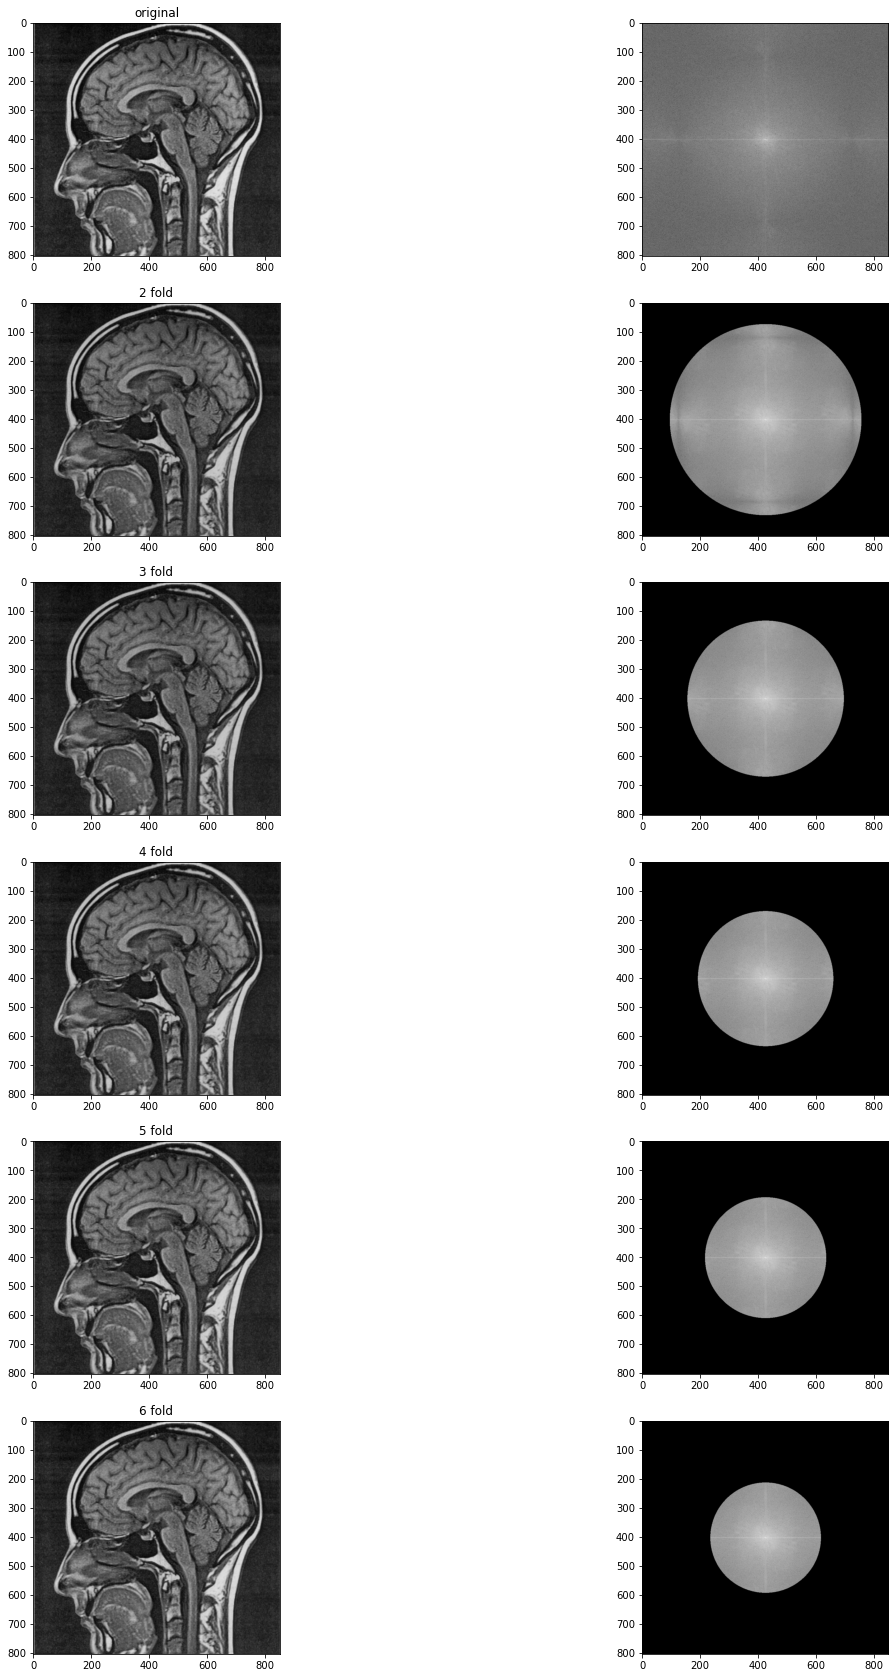

In [61]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1+len(factors),2,figsize=(20,30)) 

for i in range(len(factors)):
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0][0].imshow(img,cmap='gray')
    axarr[0][0].set_title('original')
    axarr[0][1].imshow(display(kspace),cmap='gray')
    axarr[i+1][0].imshow(img_trans[i],cmap='gray')
    axarr[i+1][0].set_title(f'{factors[i] } fold')
    axarr[i+1][1].imshow(display(kspace_trans[i]),cmap='gray')


In [49]:
img_trans[4,:]

array([[220.82857 , 257.05338 , 225.44832 , ...,  89.68013 ,  90.70712 ,
        144.48209 ],
       [227.62857 , 258.68182 , 223.26753 , ..., 105.85382 , 105.72067 ,
        156.20857 ],
       [218.76576 , 256.98132 , 224.64458 , ...,  75.29492 ,  79.579895,
        138.082   ],
       ...,
       [200.06285 , 257.71317 , 235.63264 , ...,   9.349104,  20.049503,
         96.25157 ],
       [197.38834 , 255.10133 , 235.0398  , ...,  11.736478,  21.77075 ,
         95.660904],
       [205.84535 , 254.62805 , 230.47374 , ...,  44.625076,  50.68671 ,
        115.407166]], dtype=float32)

In [50]:
img.shape

(804, 850)

In [51]:
for i in range(len(factors)):
    im = Image.fromarray(img_trans[i,:])
    im = im.convert('RGB')
    im.save(str(i)+"-fold.jpeg")

In [56]:
with Image.open(path) as f:
    img_file = f.convert('F')  # 'F' mode: 32-bit floating point pixels
    img = np.array(img_file).astype(dtype)
img

array([[255., 255., 231., ..., 122., 114., 112.],
       [255., 255., 231., ..., 122., 114., 114.],
       [255., 255., 231., ..., 106.,  98.,  98.],
       ...,
       [255., 255., 233., ...,  40.,  40.,  40.],
       [255., 255., 233., ...,  42.,  38.,  36.],
       [255., 255., 233., ...,  44.,  38.,  36.]], dtype=float32)

In [57]:
with Image.open(path) as f:
    img_file = f.convert('F')  # 'F' mode: 32-bit floating point pixels
    img = np.array(f).astype(dtype)
img

array([[ 86.,  86., 169., ...,  41.,  33.,  30.],
       [ 86.,  86., 169., ...,  41.,  33.,  33.],
       [ 86.,  86., 169., ...,  27.,  23.,  23.],
       ...,
       [ 86.,  86., 112., ...,   0.,   0.,   0.],
       [ 86.,  86., 112., ...,   6.,   4.,   7.],
       [ 86.,  86., 112., ...,   9.,   4.,   7.]], dtype=float32)

In [58]:
kspace_trans[1]

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

In [66]:
f.n_frames

1

In [67]:
img.shape

(804, 850)